# Tutorial 10

## template fitting pysm data test (B mode)

The `simple likelihood` is designed for pipeline's sanity check:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import afra as af
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cambmodel
import seaborn as sns
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

#np.random.seed(233)

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### run `preprocess` to get covariance matrix M and noise average

In [2]:
%%time

FREQS = [95.,150.]
NMAP = 2

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

tmpmap = dict()
tmpmap[30] = map30f[1:]
tmpmap[353] = map353f[1:]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=None,
                      likelihood='simple',foreground=syncdustmodel,background=cambmodel)

RESAMP = 30
APOSCALE = 6.
PSBIN = 40
LMIN = 50
LMAX = 200

pipeline.debug=False
inter = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,nsamp=RESAMP)

CPU times: user 32min 26s, sys: 4.37 s, total: 32min 30s
Wall time: 4min 7s


#### run `analyse` to apply Bayesian sampler

- with simple (Gaussian) likelihood

iter: 7346 | +1000 | bound: 9 | nc: 1 | ncall: 47885 | eff(%): 17.429 | loglstar:   -inf < -2.107 <    inf | logz: -9.517 +/-  0.133 | dlogz:  0.001 >  1.009                                         

CPU times: user 33 s, sys: 2.28 s, total: 35.3 s
Wall time: 31.1 s


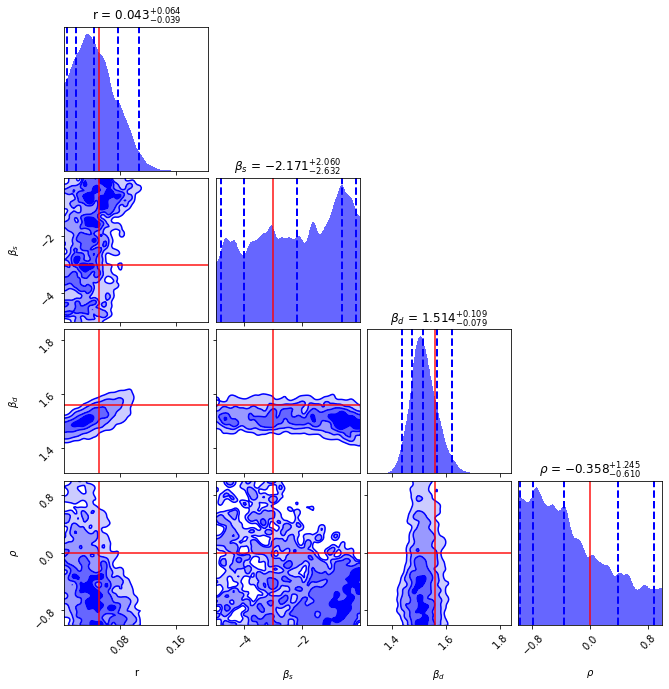

In [3]:
%%time

KWARGS = {'nlive':1000}
pipeline.param_range = {'r':[0,0.5]}
result = pipeline.analyse(inter[0],inter[1],inter[2],inter[3],kwargs=KWARGS)

truths = [0.05,-3.,1.56,0.]
labels = [r'r',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.16, 0.5, 0.84, 0.975])

- with HL likelihood

iter: 6443 | +1000 | bound: 7 | nc: 1 | ncall: 44875 | eff(%): 16.586 | loglstar:   -inf < -1.439 <    inf | logz: -7.972 +/-  0.131 | dlogz:  0.001 >  1.009                                         

CPU times: user 1min 19s, sys: 2.47 s, total: 1min 21s
Wall time: 1min 17s


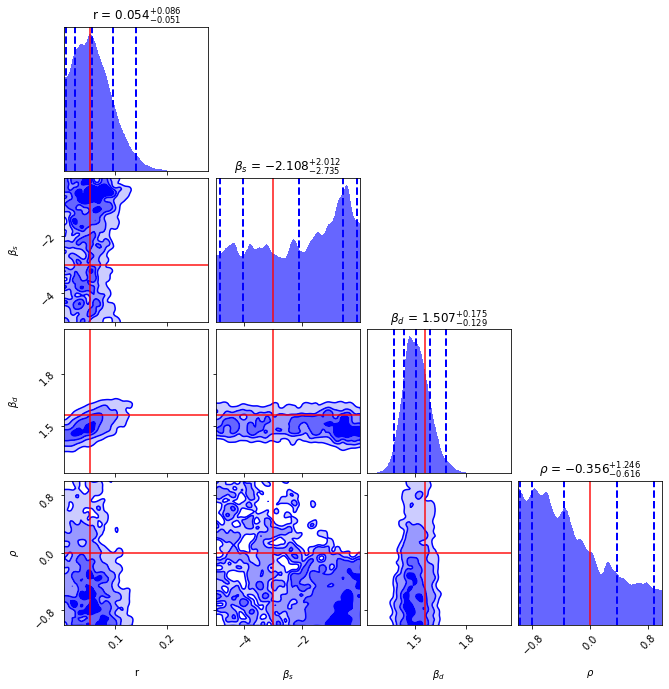

In [4]:
%%time

KWARGS = {'nlive':1000}

pipeline.likelihood = 'hl'
result = pipeline.analyse(inter[0],inter[1],inter[2],inter[3],kwargs=KWARGS)

truths = [0.05,-3.,1.56,0.]
labels = [r'r',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.16, 0.5, 0.84, 0.975])

#### process new measurements with `reprocess`, run Bayesian analysis again

iter: 6970 | +1000 | bound: 8 | nc: 1 | ncall: 46824 | eff(%): 17.021 | loglstar:   -inf < -2.095 <    inf | logz: -8.981 +/-  0.113 | dlogz:  0.001 >  1.009                                         

r 0.06650718512104177 0.03845671096119266
$\beta_s$ -2.6132648958077462 1.3752869405919075
$\beta_d$ 1.621757884229996 0.09412307868155387
$\rho$ -0.033132749984077475 0.5594946397509155
CPU times: user 13min, sys: 16.6 s, total: 13min 16s
Wall time: 5min 32s


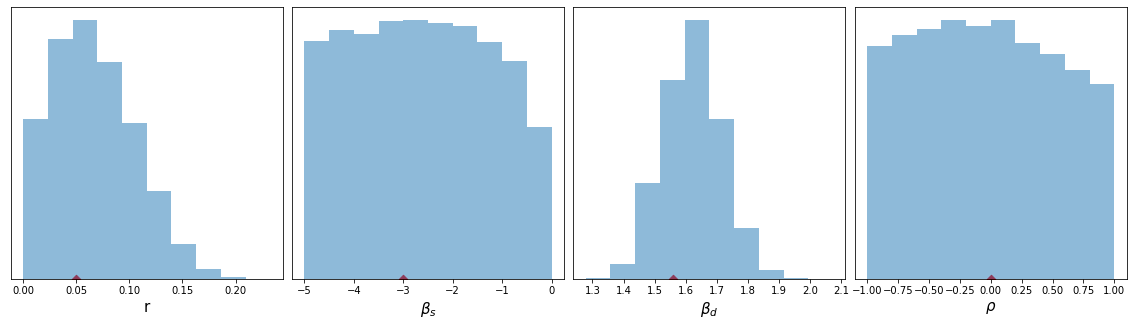

In [5]:
%%time
# re-run the analysis many times
rerun = 10

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])

for i in range(rerun):
    # remock measurements
    nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
    nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)
    ell = np.arange(cmb_cl.shape[1])
    mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
    map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
    map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150
    fullmap = dict()
    fullmap[95] = map95[1:]
    fullmap[150] = map150[1:]
    # re-process new measurements
    new_x = pipeline.reprocess(fullmap)
    # re-run Bayesian analysis
    KWARGS = {'nlive':1000}
    pipeline.likelihood = 'simple'
    pipeline.param_range = {'r':[0,0.5]}
    result = pipeline.analyse(new_x,inter[1],inter[2],inter[3],kwargs=KWARGS)
    _samples, _weights = result.samples, np.exp(result.logwt - result.logz[-1])
    samples = np.r_[samples,_samples]
    weights = np.r_[weights,_weights]
    
resamples = dyfunc.resample_equal(samples, weights)

fig = plt.figure(figsize=(20,5))
gs = gsp.GridSpec(5, 20)

for i in range(4):
    ax = fig.add_subplot(gs[:,i*5:(i+1)*5])
    ax.hist(resamples[:,i],density=True,alpha=0.5)
    ax.scatter(truths[i],0,marker='D',color='red')
    ax.set_xlabel(labels[i],fontsize=15)
    ax.set_yticks([])
    print (labels[i],np.mean(resamples[:,i]),np.std(resamples[:,i]))

iter: 5361 | +1000 | bound: 5 | nc: 1 | ncall: 41254 | eff(%): 15.419 | loglstar:   -inf < -2.178 <    inf | logz: -7.399 +/-  0.096 | dlogz:  0.001 >  1.009                                         

r 0.08138193827526043 0.04957160146358983
$\beta_s$ -2.6290349636358044 1.3760509320168555
$\beta_d$ 1.657830480724143 0.14002224789891024
$\rho$ 0.012207987805682913 0.565388020844435
CPU times: user 21min 45s, sys: 18.2 s, total: 22min 4s
Wall time: 14min


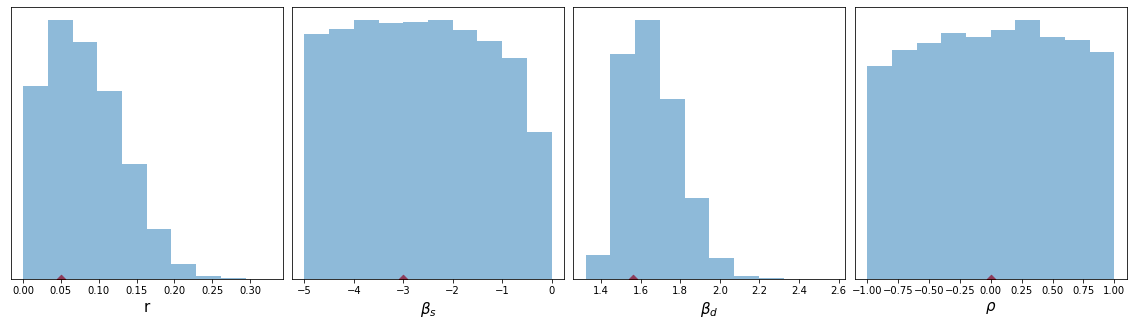

In [6]:
%%time
# re-run the analysis many times
rerun = 10

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])

for i in range(rerun):
    # remock measurements
    nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
    nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)
    ell = np.arange(cmb_cl.shape[1])
    mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
    map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
    map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150
    fullmap = dict()
    fullmap[95] = map95[1:]
    fullmap[150] = map150[1:]
    # re-process new measurements
    new_x = pipeline.reprocess(fullmap)
    # re-run Bayesian analysis
    KWARGS = {'nlive':1000}
    pipeline.likelihood = 'hl'
    pipeline.param_range = {'r':[0,0.5]}
    result = pipeline.analyse(new_x,inter[1],inter[2],inter[3],kwargs=KWARGS)
    _samples, _weights = result.samples, np.exp(result.logwt - result.logz[-1])
    samples = np.r_[samples,_samples]
    weights = np.r_[weights,_weights]
    
resamples = dyfunc.resample_equal(samples, weights)

fig = plt.figure(figsize=(20,5))
gs = gsp.GridSpec(5, 20)

for i in range(4):
    ax = fig.add_subplot(gs[:,i*5:(i+1)*5])
    ax.hist(resamples[:,i],density=True,alpha=0.5)
    ax.scatter(truths[i],0,marker='D',color='red')
    ax.set_xlabel(labels[i],fontsize=15)
    ax.set_yticks([])
    print (labels[i],np.mean(resamples[:,i]),np.std(resamples[:,i]))

end